<a href="https://colab.research.google.com/github/mett29/DL-Competition/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary steps

In [ ]:
# This permits to let colab save model on Gdrive
from google.colab import drive
googleDrivePath = 'drive'
drive.mount('/content/'+googleDrivePath)

In [2]:
from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

#!git clone https://$GITHUB_AUTH@github.com/mett29/DL-Competition.git
#!git submodule update --init --recursive
!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 2079, done.
remote: Total 2079 (delta 0), reused 0 (delta 0), pack-reused 2079
Receiving objects: 100% (2079/2079), 90.16 MiB | 29.14 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate

import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (78.0 kB/s)
Selecting previously unselected package tree.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
PATH = "DL-CompetitionsDatasets/Classification_Dataset"
!tree DL-CompetitionsDatasets/Classification_Dataset/ -d

DL-CompetitionsDatasets/Classification_Dataset/
├── test
└── training
    ├── airplanes
    ├── bear
    ├── calculator
    ├── computer-monitor
    ├── fireworks
    ├── galaxy
    ├── grand-piano
    ├── kangaroo
    ├── laptop
    ├── lightbulb
    ├── lightning
    ├── mountain-bike
    ├── owl
    ├── school-bus
    ├── sheet-music
    ├── skyscraper
    ├── sword
    ├── t-shirt
    ├── waterfall
    └── wine-bottle

22 directories


# Dataset splitting and augmentation

**NOTE:** the *batch_size* and the *rotation_range* you read here are the ones related to the transfer learning models,
and not the one used to train the base model. The same holds for *IMG_HEIGHT* and *IMG_WIDTH*, which are now set
according to the pretrained models.

In [0]:
SEED = 1234
tf.random.set_seed(SEED)

In [0]:
apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(zoom_range=0.1,
                                        rotation_range=90,
                                        horizontal_flip=True,
                                        vertical_flip=False,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        fill_mode='nearest',
                                        cval=0,
                                        validation_split=0.2)

In [10]:
batch_size = 32
no_epochs = 50
no_classes = 20

IMG_HEIGHT = 299
IMG_WIDTH = 299

decide_class_indices = True
if decide_class_indices:
    classes = ['owl',                   # 0
               'galaxy',                # 1
               'lightning',             # 2
               'wine-bottle',           # 3
               't-shirt',               # 4
               'waterfall',             # 5
               'sword',                 # 6
               'school-bus',            # 7
               'calculator',            # 8
               'sheet-music',           # 9
               'airplanes',             # 10
               'lightbulb',             # 11
               'skyscraper',            # 12
               'mountain-bike',         # 13
               'fireworks',             # 14
               'computer-monitor',      # 15
               'bear',                  # 16
               'grand-piano',           # 17
               'kangaroo',              # 18
               'laptop']                # 19
else:
    classes=None

dataset_dir = os.path.join(PATH, 'training')

train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)

# Validation
valid_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED)

Found 1247 images belonging to 20 classes.
Found 307 images belonging to 20 classes.


In [19]:
# Produce json
train = {}
for f in (train_gen.filenames):
    (category, img_path) = f.split('/') 
    if category not in train:
        train[category] = []

    train[category].append(img_path)

print('json train:')
print(train)

valid = {}
for f in (valid_gen.filenames):
    (category, img_path) = f.split('/') 
    if category not in valid:
        valid[category] = []

    valid[category].append(img_path)

print('json validation:')
print(valid)

json train:
{'owl': ['IMG_1223.jpg', 'IMG_1236.jpg', 'IMG_1275.jpg', 'IMG_1286.jpg', 'IMG_1301.jpg', 'IMG_1319.jpg', 'IMG_1326.jpg', 'IMG_1362.jpg', 'IMG_1366.jpg', 'IMG_1373.jpg', 'IMG_1375.jpg', 'IMG_1380.jpg', 'IMG_1388.jpg', 'IMG_1403.jpg', 'IMG_1423.jpg', 'IMG_1425.jpg', 'IMG_1432.jpg', 'IMG_146.jpg', 'IMG_1482.jpg', 'IMG_1598.jpg', 'IMG_1673.jpg', 'IMG_1677.jpg', 'IMG_1694.jpg', 'IMG_1711.jpg', 'IMG_1714.jpg', 'IMG_1715.jpg', 'IMG_1753.jpg', 'IMG_1766.jpg', 'IMG_1779.jpg', 'IMG_1795.jpg', 'IMG_1841.jpg', 'IMG_1920.jpg', 'IMG_1922.jpg', 'IMG_1927.jpg', 'IMG_1954.jpg', 'IMG_1980.jpg', 'IMG_1983.jpg', 'IMG_1993.jpg', 'IMG_1997.jpg', 'IMG_2011.jpg', 'IMG_2048.jpg', 'IMG_258.jpg', 'IMG_26.jpg', 'IMG_274.jpg', 'IMG_290.jpg', 'IMG_319.jpg', 'IMG_330.jpg', 'IMG_332.jpg', 'IMG_357.jpg', 'IMG_399.jpg', 'IMG_431.jpg', 'IMG_434.jpg', 'IMG_462.jpg', 'IMG_484.jpg', 'IMG_50.jpg', 'IMG_530.jpg', 'IMG_541.jpg', 'IMG_571.jpg', 'IMG_575.jpg', 'IMG_595.jpg', 'IMG_612.jpg', 'IMG_65.jpg', 'IMG_661.jpg

In [0]:
# This function will plot images in the form of a grid with 1 row and 4 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# train_gen.class_indices

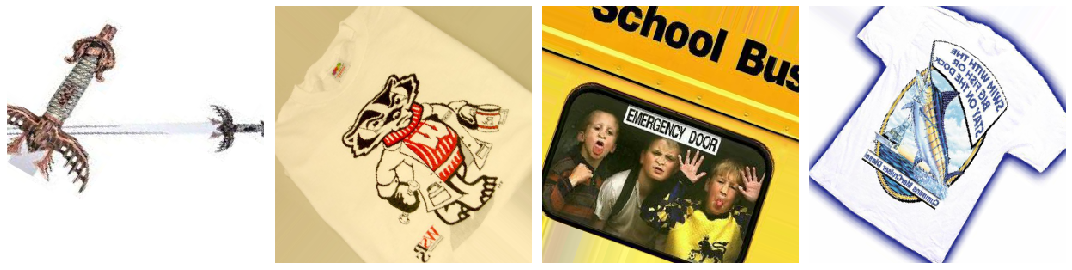

In [0]:
sample_training_images, _ = next(train_gen)
plotImages(sample_training_images[:4])

In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

valid_dataset = valid_dataset.repeat()

# Model creation

The following two models are the ones which obtained the best accuracy on the test set. However, they overfits after $\sim$0.60 accuracy on the validation set.

In [0]:
'''This is the first model with which we got a score over 60%, i.e. 0.60600 on the test set'''

def get_model1():

    model = Sequential([               
      Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      MaxPooling2D(),

      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(128, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(256, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Dropout(0.4),

      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(20, activation='softmax')
    ])

    return model

In [0]:
'''This is an improvement of the previous model, with which we got the score 0.62400 on the test set'''

def get_model2():
    input_l = Input( (IMG_HEIGHT, IMG_WIDTH, 3)) 

    conv1   = Conv2D(32, 3, padding='same', activation='relu')(input_l)
    max1    = MaxPooling2D()(conv1)
    drop1   = Dropout(0.2)(max1)

    conv2   = Conv2D(64, 3, padding='same', activation='relu')(drop1)
    max2    = MaxPooling2D()(conv2)
    drop2   = Dropout(0.3)(max2)

    conv3   = Conv2D(128, 3, padding='same', activation='relu')(drop2)
    max3    = MaxPooling2D()(conv3)
    drop3   = Dropout(0.4)(max3)

    conv4   = Conv2D(256, 3, padding='same', activation='relu')(drop3)
    max4    = MaxPooling2D()(conv4)
    drop4   = Dropout(0.5)(max4)
    flat    = Flatten()(drop3)

    globalAverage = GlobalAveragePooling2D()(drop1)
    globalMax = GlobalMaxPooling2D()(drop1)
    
    feat = Concatenate()([flat, globalAverage, globalMax])
    d1   = Dense(512, activation='relu')(feat)
    drop4= Dropout(0.4)(d1)
    output_l   = Dense(20, activation='softmax')(drop4)
    model = tf.keras.Model(input_l, output_l)

    return model 

In [ ]:
base_model = get_model2()
base_model.summary()

# Transfer Learning

Once we tried many different models in order to reach an higher accuracy on the validation set without overfitting, we skipped to transfer learning.
The following are the most important milestones we reached (the accuracy refers to the Kaggle's leaderboard):

- VGG16 $\rightarrow$ this model was good but not enough to reach a score above 0.90
- InceptionV3 $\rightarrow$ among the other this was the most promising. We reached 0.96200
- InceptionV3 with Fine Tuning $\rightarrow$ 0.97600 (we freeze until the 94th layer)
- InceptionV3 fine-tuned + Xception fine-tuned $\rightarrow$ 0.97800 (once trained the two models we took the average of the respective predictions' probability vectors)
- InceptionV3 fine-tuned + Xception fine-tuned + DenseNet201 fine-tuned $\rightarrow$ 0.98200 (in this case we used 'voting' in order to make predictions; if they all predict a different class, we take the average)

In [0]:
# InceptionV3
InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

finetuning = True

if finetuning:
    freeze_until = 94 # layer from which we want to fine-tune
    
    for layer in InceptionV3.layers[:freeze_until]:
        layer.trainable = False
else:
    InceptionV3.trainable = False
    
inception_model = tf.keras.Sequential()
inception_model.add(InceptionV3)
inception_model.add(tf.keras.layers.Flatten())
inception_model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
inception_model.add(tf.keras.layers.Dropout(0.5))
inception_model.add(tf.keras.layers.Dense(units=no_classes, activation='softmax'))

# Visualize created model as a table
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
Total params: 156,042,036
Trainable params: 153,949,044
Non-trainable params: 2,092,992
_________________________________________________________________


In [0]:
# Xception
Xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

finetuning = True

if finetuning:
    freeze_until = 126 # layer from which we want to fine-tune
    
    for layer in Xception.layers[:freeze_until]:
        layer.trainable = False
else:
    Xception.trainable = False
    
xception_model = tf.keras.Sequential()
xception_model.add(Xception)
xception_model.add(tf.keras.layers.Flatten())
xception_model.add(tf.keras.layers.Dense(units=512, activation='relu'))
xception_model.add(tf.keras.layers.Dropout(0.5))
xception_model.add(tf.keras.layers.Dense(units=no_classes, activation='softmax'))

# Visualize created model as a table
xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                10260     
Total params: 125,729,852
Trainable params: 109,617,172
Non-trainable params: 16,112,680
_________________________________________________________________


In [0]:
# DenseNet201
DenseNet201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

finetuning = True

if finetuning:
    freeze_until = 120 # layer from which we want to fine-tune
    
    for layer in DenseNet201.layers[:freeze_until]:
        layer.trainable = False
else:
    DenseNet201.trainable = False
    
densenet_model = tf.keras.Sequential()
densenet_model.add(DenseNet201)
densenet_model.add(tf.keras.layers.Flatten())
densenet_model.add(tf.keras.layers.Dense(units=512, activation='relu'))
densenet_model.add(tf.keras.layers.Dropout(0.5))
densenet_model.add(tf.keras.layers.Dense(units=no_classes, activation='softmax'))

# Visualize created model as a table
densenet_model.summary()

74842112/74836368 [==============================] - 6s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_10 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               48169472  
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                10260     
Total params: 66,501,716
Trainable params: 65,206,868
Non-trainable params: 1,294,848
_________________________________________________________________


# Model compile and callbacks

The following are the optimization parameters we used when doing transfer learning. Since we are using pretrained models, the **learning rate** has been set to a low value. The optimizer has been changed from Adam to **SGD** with high **momentum** value for the same reason, and also 'cause in practice it works better.

In [0]:
# Optimization parameters
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

# Validation metrics
metrics = ['accuracy']

# Compile Model
inception_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
from datetime import datetime

# Callbacks

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

# Training

In [0]:
# Training of fine-tuned DenseNet201

history = densenet_model.fit(x=train_dataset,
          epochs=no_epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks
         )

densenet_model.save_weights(str(datetime.now().strftime('%b%d_%H-%M')) + "_try.h5")

Train for 39 steps, validate for 10 steps
Epoch 1/50
39/39 [==============================] - 109s 3s/step - loss: 2.7824 - accuracy: 0.2582 - val_loss: 1.2955 - val_accuracy: 0.6808
Epoch 2/50
39/39 [==============================] - 61s 2s/step - loss: 1.0680 - accuracy: 0.6913 - val_loss: 0.6736 - val_accuracy: 0.8241
Epoch 3/50
39/39 [==============================] - 61s 2s/step - loss: 0.6202 - accuracy: 0.8196 - val_loss: 0.5187 - val_accuracy: 0.8339
Epoch 4/50
39/39 [==============================] - 61s 2s/step - loss: 0.4401 - accuracy: 0.8789 - val_loss: 0.4594 - val_accuracy: 0.8567
Epoch 5/50
39/39 [==============================] - 62s 2s/step - loss: 0.3633 - accuracy: 0.8941 - val_loss: 0.4033 - val_accuracy: 0.8762
Epoch 6/50
39/39 [==============================] - 62s 2s/step - loss: 0.2976 - accuracy: 0.9078 - val_loss: 0.4528 - val_accuracy: 0.8469
Epoch 7/50
39/39 [==============================] - 61s 2s/step - loss: 0.2309 - accuracy: 0.9350 - val_loss: 0.4109 

In [0]:
# Training of fine-tuned Xception

history = xception_model.fit(x=train_dataset,
          epochs=no_epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks
         )

xception_model.save_weights(str(datetime.now().strftime('%b%d_%H-%M')) + "_try.h5")

Train for 39 steps, validate for 10 steps
Epoch 1/50
39/39 [==============================] - 76s 2s/step - loss: 2.3356 - accuracy: 0.3577 - val_loss: 1.3172 - val_accuracy: 0.7524
Epoch 2/50
39/39 [==============================] - 71s 2s/step - loss: 1.0205 - accuracy: 0.7458 - val_loss: 0.6325 - val_accuracy: 0.8795
Epoch 3/50
39/39 [==============================] - 71s 2s/step - loss: 0.6441 - accuracy: 0.8356 - val_loss: 0.4774 - val_accuracy: 0.9023
Epoch 4/50
39/39 [==============================] - 72s 2s/step - loss: 0.4830 - accuracy: 0.8837 - val_loss: 0.3984 - val_accuracy: 0.9153
Epoch 5/50
39/39 [==============================] - 71s 2s/step - loss: 0.4194 - accuracy: 0.8901 - val_loss: 0.3661 - val_accuracy: 0.9121
Epoch 6/50
39/39 [==============================] - 72s 2s/step - loss: 0.3315 - accuracy: 0.9094 - val_loss: 0.3170 - val_accuracy: 0.9153
Epoch 7/50
39/39 [==============================] - 72s 2s/step - loss: 0.2875 - accuracy: 0.9262 - val_loss: 0.3496 -

In [0]:
# Training of fine-tuned InceptionV3

history = inception_model.fit(x=train_dataset,
          epochs=no_epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks,
          
         )

inception_model.save_weights(str(datetime.now().strftime('%b%d_%H-%M')) + "_try.h5")

Train for 39 steps, validate for 10 steps
Epoch 1/50
39/39 [==============================] - 80s 2s/step - loss: 2.3914 - accuracy: 0.3585 - val_loss: 0.8596 - val_accuracy: 0.8046
Epoch 2/50
39/39 [==============================] - 66s 2s/step - loss: 0.8964 - accuracy: 0.7658 - val_loss: 0.4614 - val_accuracy: 0.8795
Epoch 3/50
39/39 [==============================] - 66s 2s/step - loss: 0.5053 - accuracy: 0.8605 - val_loss: 0.3121 - val_accuracy: 0.9153
Epoch 4/50
39/39 [==============================] - 66s 2s/step - loss: 0.3453 - accuracy: 0.9166 - val_loss: 0.3450 - val_accuracy: 0.9153
Epoch 5/50
39/39 [==============================] - 66s 2s/step - loss: 0.2548 - accuracy: 0.9342 - val_loss: 0.2501 - val_accuracy: 0.9381
Epoch 6/50
39/39 [==============================] - 66s 2s/step - loss: 0.2123 - accuracy: 0.9431 - val_loss: 0.2279 - val_accuracy: 0.9511
Epoch 7/50
39/39 [==============================] - 66s 2s/step - loss: 0.1876 - accuracy: 0.9439 - val_loss: 0.2080 -

# Plotting graph

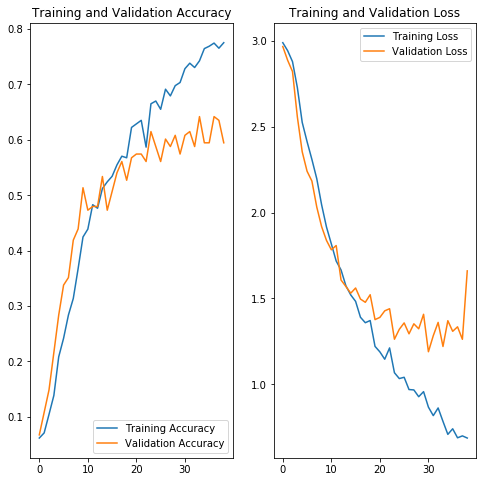

In [0]:
# Without Transfer Learning: clear overfitting

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(39)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

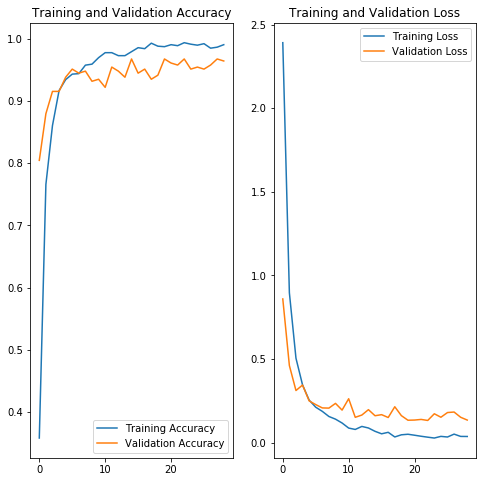

In [0]:
# With Transfer Learning (InceptionV3 fine-tuned): much better

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predictions and CSV creation

In [0]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [0]:
image_filenames = next(os.walk('DL-CompetitionsDatasets/Classification_Dataset/test'))[2]

# This is due to the fact that DenseNet201 has a different input size with respect to InceptionV3 and Xception
def get_prediction_densenet(image_name):
    img = image.load_img(os.path.join('DL-CompetitionsDatasets/Classification_Dataset/test/', image_name), target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.

    return img_tensor

results = {}
for image_name in image_filenames:

    img = image.load_img(os.path.join('DL-CompetitionsDatasets/Classification_Dataset/test/', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 

    prediction_model_1 = xception_model.predict(img_tensor, batch_size=64) # Xception
    prediction_model_2 =  inception_model.predict(img_tensor, batch_size=64) # InceptionV3
    prediction_model_3 = densenet_model.predict(get_prediction_densenet(image_name), batch_size=64) # DenseNet201

    #print(prediction_model_1)
    #print(prediction_model_2)
    #print(prediction_model_3)

    prediction_1 = np.argmax(prediction_model_1)
    prediction_2 = np.argmax(prediction_model_2)
    prediction_3 = np.argmax(prediction_model_3)

    predictions = [prediction_1, prediction_2, prediction_3]

    # Voting
    
    if (predictions.count(prediction_1) > 1):
    final_prediction = prediction_1
    elif (predictions.count(prediction_2) > 1):
    final_prediction = prediction_2
    elif (predictions.count(prediction_3) > 1):
    final_prediction = prediction_3
    else:
    average = np.zeros(len(prediction_model_1[0]))

    for i in range(len(average)):
        average[i] = (prediction_model_1[0][i] + prediction_model_2[0][i] + prediction_model_3[0][i]) / 3

    final_prediction = np.argmax(average)

    ''' max_1 = np.max(prediction_model_1)
    max_2 = np.max(prediction_model_2)
    if (max_1 >= max_2):
    prediction = np.argmax(prediction_model_1)
    else:
    prediction = np.argmax(prediction_model_2) '''

    results[image_name] = final_prediction

In [0]:
results # ensembled (all the three models with voting)

{'IMG_0.jpg': 17,
 'IMG_1001.jpg': 16,
 'IMG_1007.jpg': 14,
 'IMG_1011.jpg': 15,
 'IMG_1023.jpg': 0,
 'IMG_1031.jpg': 17,
 'IMG_1035.jpg': 13,
 'IMG_1037.jpg': 7,
 'IMG_104.jpg': 7,
 'IMG_1042.jpg': 19,
 'IMG_1046.jpg': 19,
 'IMG_105.jpg': 7,
 'IMG_1050.jpg': 0,
 'IMG_1052.jpg': 16,
 'IMG_1058.jpg': 17,
 'IMG_1059.jpg': 16,
 'IMG_106.jpg': 9,
 'IMG_1071.jpg': 0,
 'IMG_1072.jpg': 14,
 'IMG_1073.jpg': 7,
 'IMG_1074.jpg': 7,
 'IMG_1080.jpg': 3,
 'IMG_1084.jpg': 5,
 'IMG_1090.jpg': 12,
 'IMG_1094.jpg': 7,
 'IMG_1097.jpg': 18,
 'IMG_1099.jpg': 11,
 'IMG_1101.jpg': 13,
 'IMG_1117.jpg': 10,
 'IMG_1119.jpg': 4,
 'IMG_1127.jpg': 7,
 'IMG_113.jpg': 15,
 'IMG_1133.jpg': 12,
 'IMG_1137.jpg': 14,
 'IMG_1143.jpg': 15,
 'IMG_1147.jpg': 6,
 'IMG_1148.jpg': 16,
 'IMG_1155.jpg': 8,
 'IMG_1158.jpg': 5,
 'IMG_1163.jpg': 17,
 'IMG_117.jpg': 19,
 'IMG_1172.jpg': 15,
 'IMG_1174.jpg': 8,
 'IMG_1179.jpg': 11,
 'IMG_1183.jpg': 2,
 'IMG_1187.jpg': 12,
 'IMG_119.jpg': 9,
 'IMG_1194.jpg': 8,
 'IMG_1196.jpg': 1,
 '

In [0]:
results # ensembled (average between InceptionV3 and Xception)

{'IMG_0.jpg': 17,
 'IMG_1001.jpg': 16,
 'IMG_1007.jpg': 14,
 'IMG_1011.jpg': 15,
 'IMG_1023.jpg': 0,
 'IMG_1031.jpg': 17,
 'IMG_1035.jpg': 13,
 'IMG_1037.jpg': 7,
 'IMG_104.jpg': 7,
 'IMG_1042.jpg': 19,
 'IMG_1046.jpg': 19,
 'IMG_105.jpg': 7,
 'IMG_1050.jpg': 0,
 'IMG_1052.jpg': 16,
 'IMG_1058.jpg': 17,
 'IMG_1059.jpg': 16,
 'IMG_106.jpg': 9,
 'IMG_1071.jpg': 0,
 'IMG_1072.jpg': 14,
 'IMG_1073.jpg': 7,
 'IMG_1074.jpg': 7,
 'IMG_1080.jpg': 3,
 'IMG_1084.jpg': 5,
 'IMG_1090.jpg': 12,
 'IMG_1094.jpg': 7,
 'IMG_1097.jpg': 18,
 'IMG_1099.jpg': 11,
 'IMG_1101.jpg': 13,
 'IMG_1117.jpg': 10,
 'IMG_1119.jpg': 4,
 'IMG_1127.jpg': 7,
 'IMG_113.jpg': 15,
 'IMG_1133.jpg': 12,
 'IMG_1137.jpg': 14,
 'IMG_1143.jpg': 15,
 'IMG_1147.jpg': 6,
 'IMG_1148.jpg': 16,
 'IMG_1155.jpg': 8,
 'IMG_1158.jpg': 5,
 'IMG_1163.jpg': 17,
 'IMG_117.jpg': 19,
 'IMG_1172.jpg': 15,
 'IMG_1174.jpg': 8,
 'IMG_1179.jpg': 11,
 'IMG_1183.jpg': 12,
 'IMG_1187.jpg': 12,
 'IMG_119.jpg': 9,
 'IMG_1194.jpg': 8,
 'IMG_1196.jpg': 1,
 

In [0]:
results # InceptionV3 fine-tuned

{'IMG_0.jpg': 17,
 'IMG_1001.jpg': 16,
 'IMG_1007.jpg': 14,
 'IMG_1011.jpg': 15,
 'IMG_1023.jpg': 0,
 'IMG_1031.jpg': 17,
 'IMG_1035.jpg': 13,
 'IMG_1037.jpg': 7,
 'IMG_104.jpg': 7,
 'IMG_1042.jpg': 19,
 'IMG_1046.jpg': 19,
 'IMG_105.jpg': 7,
 'IMG_1050.jpg': 0,
 'IMG_1052.jpg': 16,
 'IMG_1058.jpg': 17,
 'IMG_1059.jpg': 16,
 'IMG_106.jpg': 9,
 'IMG_1071.jpg': 0,
 'IMG_1072.jpg': 14,
 'IMG_1073.jpg': 7,
 'IMG_1074.jpg': 7,
 'IMG_1080.jpg': 3,
 'IMG_1084.jpg': 5,
 'IMG_1090.jpg': 12,
 'IMG_1094.jpg': 7,
 'IMG_1097.jpg': 18,
 'IMG_1099.jpg': 11,
 'IMG_1101.jpg': 13,
 'IMG_1117.jpg': 10,
 'IMG_1119.jpg': 4,
 'IMG_1127.jpg': 7,
 'IMG_113.jpg': 15,
 'IMG_1133.jpg': 12,
 'IMG_1137.jpg': 14,
 'IMG_1143.jpg': 15,
 'IMG_1147.jpg': 6,
 'IMG_1148.jpg': 16,
 'IMG_1155.jpg': 8,
 'IMG_1158.jpg': 5,
 'IMG_1163.jpg': 17,
 'IMG_117.jpg': 19,
 'IMG_1172.jpg': 15,
 'IMG_1174.jpg': 8,
 'IMG_1179.jpg': 11,
 'IMG_1183.jpg': 2,
 'IMG_1187.jpg': 12,
 'IMG_119.jpg': 9,
 'IMG_1194.jpg': 8,
 'IMG_1196.jpg': 1,
 '

In [0]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [0]:
create_csv(results)

# Extra

In [0]:
# Snippet of code used for determining some weights used to modify the loss function 
# to account for unbalanced class samples
#
# Tested but not so useful
import shutil 

max_image_count = 0
count_files = []
training_path = PATH + '/training'

for dir in classes:
    basepath = training_path + '/' + dir;
    files = [f for f in os.listdir(basepath) if os.path.isfile(basepath + "/" + f)]
    count_files.append(len(files))
    #print('files under ', dir,':', count_files[-1])
    if(count_files[-1] > max_image_count):
        max_image_count = count_files[-1];

#print('current max', max_image_count)
inverse_representativity_of_the_class = list( map(lambda x: x/max_image_count, count_files))
#print(inverse_representativity_of_the_class)

#Example of usage
#
# class_weights = {}
#for i, w in enumerate(inverse_representativity_of_the_class):
#  class_weights[str(i)] = w
#
# 
# model.fit(x=train_dataset,
#        epochs=no_epochs,
#          steps_per_epoch=len(train_gen),
#          validation_data=valid_dataset,
#          validation_steps=len(valid_gen),
#          callbacks=callbacks
#          class_weight=class_weights
#         )
#

In [0]:
# A function to perform data augmentation without relying on keras ImageGenerator
def augment_images(folder):
    for dirname in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder,dirname)):
            dir_path = os.path.join(folder, dirname)

            # Read the image
            img = cv2.imread(os.path.join(dir_path, filename))

            # Apply augmentation
            horizontal_flip = cv2.flip(img, 0)
            vertical_flip = cv2.flip(img, 1)
            matrix = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), -30, 1)
            rotated = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))
            blur = cv2.GaussianBlur(img, (55,55), 0)

            # Save into the same dir the augmented images
            cv2.imwrite(os.path.join(dir_path, str('aug_flip_hor_' + filename)), horizontal_flip)
            cv2.imwrite(os.path.join(dir_path, str('aug_flip_vert_' + filename)), vertical_flip)
            cv2.imwrite(os.path.join(dir_path, str('aug_rotated_' + filename)), rotated)
            cv2.imwrite(os.path.join(dir_path, str('aug_blur_' + filename)), blur)

    augment_images("DL-CompetitionsDatasets/Classification_Dataset/training")

In [0]:
# To remove the added images
#!rm DL-CompetitionsDatasets/Classification_Dataset/training/*/aug*.jpg

In [0]:
import os
import cv2
from google.colab.patches import cv2_imshow
import time

path = "DL-CompetitionsDatasets/Classification_Dataset/test"

filenames = []
for couple in list(results.items()):
    filenames.append(couple[0])


def load_images_from_folder(folder):
    images = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(240,240))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder(path)

for i, img in enumerate(images):
    cv2_imshow(img)
    index = int(list(results.items())[i][1])
    print(classes[index])
    time.sleep(1)

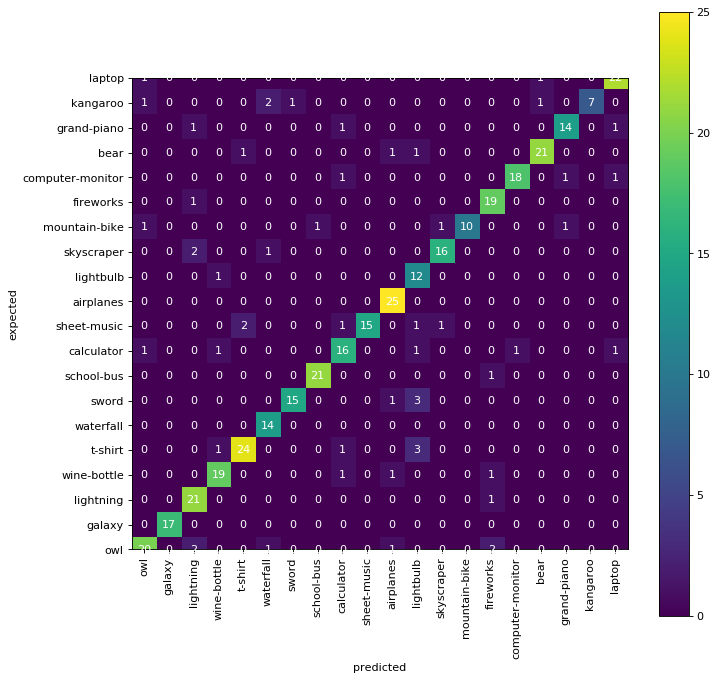

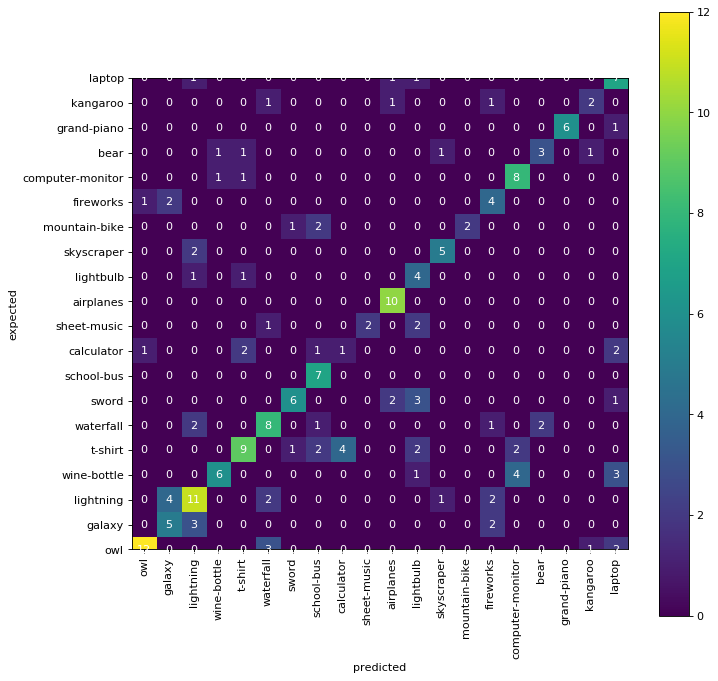

In [0]:
def computeConfusion(dataset, max_num ):
    confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        images = batch[0]
        labels = batch[1]
        for j,l in enumerate(labels):

            if(i > max_num):
                break;

            res = model.predict( tf.expand_dims(images[j], 0))
            expected = np.argmax(l)
            predicted = np.argmax(res);
            '''
            print(l, expected, res, predicted)
            plt.figure()
            plt.subplot(1, 3,1)
            plt.barh(classes,l)
            plt.subplot(1,3,2)
            plt.barh(classes,res[0])
            plt.subplot(1,3,3)
            plt.imshow(images[j])
            plt.show()
            print(expected, predicted)'''
            confusion_matrix[expected][predicted] +=1
            i+=1

    plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    im = plt.imshow(conf)
    plt.yticks(range(0,20), labels=classes);
    plt.xticks(range(0,20), labels=classes, rotation='vertical' );
    plt.ylabel("expected");
    plt.xlabel("predicted");
    plt.gca().invert_yaxis()
    plt.colorbar();

    for y in range(len(conf)):
        for x in range(len(conf[y])):
            plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 400);
computeConfusion(valid_dataset, 200);

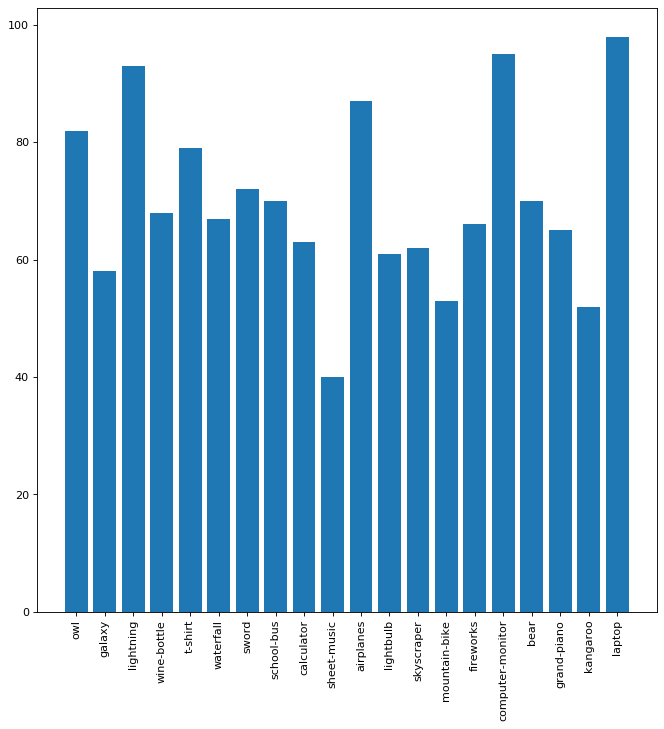

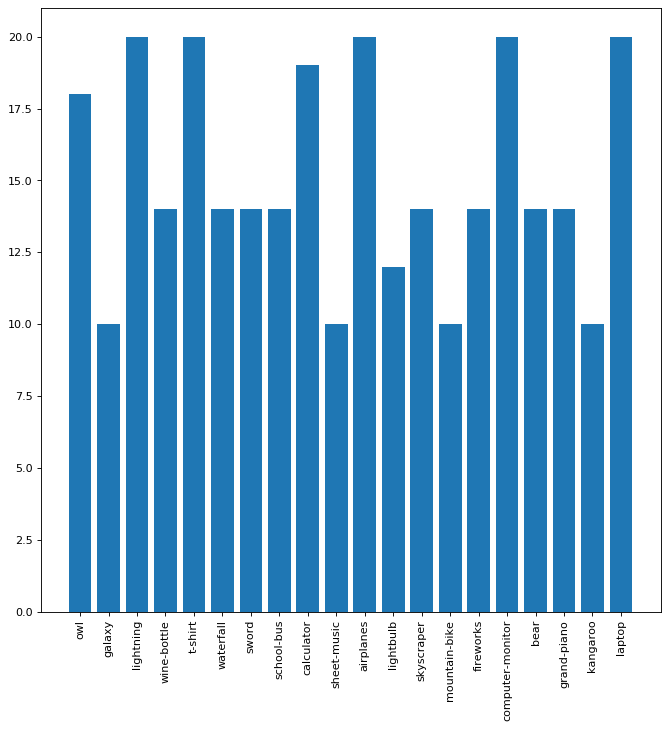

In [0]:
def plotDatasetDistribution(dataset, max_num ):
    classes_count = [0 for i in range(len(classes))]

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        labels = batch[1]
        for l in labels:
            if(i > max_num):
                break
        expected = np.argmax(l)
        classes_count[expected]+=1
        i+=1
    #print(classes_count)
    plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
    plt.bar(range(len(classes)), classes_count )
    plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
    plt.show()

plotDatasetDistribution(train_dataset, 1400)
plotDatasetDistribution(valid_dataset, 300)